In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os

from matplotlib.dates import DateFormatter

In [13]:
import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_79_01/icarus_data/database/ChannelMapICARUS_20230829.db",
                 table="pmt_placements_29aug2023"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)
    con.close()
    return df

def getChannelID(db, board, digitizer_channel):
    
    _SELDB = (db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel)
    ch = db[_SELDB].channel_id.values[0]
    return ch

def getDigitizer(db, channel):
    
    _SELCH = (db.channel_id==channel)
    return db[_SELCH].digitizer_label.values[0], db[_SELCH].digitizer_ch_number.values[0]

In [14]:
def getRun(run, mapping, path="/exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb"):
    
    files = [ f for f in os.listdir(path) if str(run) in f ]
    timestamp = files[0].split("_")[0]
    
    # load the files as a dataframe
    file = path + "/" + files[0]
    df = pd.read_csv(file, sep=",")
    
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
    df["run"] = int(run)

    print("Reading " + file + " ...")
    
    df = updateTargetBaseline(df, mapping)
    
    return df

In [15]:
def computeChannel(row, db): 

    if row["digitizer_channel"] == 15: 
        return 1000
    return getChannelID(db, row["board"],row["digitizer_channel"])

def updateTargetBaseline(df, mapping, cpath="/exp/icarus/data/users/mvicenzi/pmt-baselines/configdb"):
    
    run = df["run"].values[0]
    db = readSqlitedb()
    
    for key, item in mapping.items():
                
        if run >= key[0] & run <= key[1]:
            dfconfig = pd.read_csv(cpath+"/"+item)
            dfconfig["ch"] = dfconfig.apply(computeChannel, axis=1, args=(db,)) 
            df_merged = pd.merge(df, dfconfig, on='ch')
            df_merged["bias"] = df_merged["baseline"]-df_merged["target_baseline"]
            return df_merged
        
    print("ERROR: no config found for run "+str(run))
    return df

In [16]:
def loadData(rrange, mapping, path="/exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb"):
    
    runs = [ f.split("_")[-1].lstrip('run').rstrip('.csv') for f in os.listdir(path) if "measChannelBaselines" in f ]

    # Load the data 
    data = pd.concat([ getRun(r, mapping, path) for r in runs ])
    
    # keep data only for the selected interval
    _SEL = (data.run>=rrange[0]) & (data.run<=rrange[1])
        
    return data[_SEL]

In [17]:
def extract_plotting_data(df):

    runs = np.unique(df.run.to_numpy())
    channels = np.unique(df.ch.to_numpy())

    rtimes = []
    rmedians = []
    rmeans = []
    rrms = []
    rpos = []
    rneg = []
    rrun = []
    
    for r in runs:
    
        _SELR = (df.run==r)
        tfirst = min(np.unique(df[_SELR].timestamp))
        _SELT = (df.timestamp==tfirst)
    
        fdate = np.unique(df[_SELR&_SELT].datetime)[0]
    
        diffs = []
    
        for c in channels:
            _SELC = (df.ch==c)
            
            if( len(df[_SELR&_SELC].bias) < 1 ):
                print( r, c)
            diffs.append(np.mean(df[_SELR&_SELC].bias.to_numpy()))
            
        rrun.append(r)     
        rtimes.append(fdate)
        rmedians.append(np.median(diffs))
        rmeans.append(np.mean(diffs))
        rrms.append(np.std(diffs))
        
        ma = max(diffs)
        mi = min(diffs)       
        if ma < 0:
            ma = 0
        if mi > 0:
            mi = 0
            
        rpos.append(ma)
        rneg.append(mi)

    return rrun, rtimes, rmedians, rmeans, rrms, rpos, rneg

## CHECK BASELINE TIME-VARIATION

In [18]:
### DEFINE THE FULL RANGE
rrange=(10931,12200)

### DEFINE THE CONFIGURED PEDESTAL
### ADD RUN-RANGE + CONFIGURATION FILE IN DB
mapping = {
    (11805,12200) : "PMT_Standard_Run3_data.csv"
}

df = loadData(rrange, mapping)

Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1717608927_measChannelBaselines_run11972.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1711459814_measChannelBaselines_run11830.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1698940969_measChannelBaselines_run10992.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1712336984_measChannelBaselines_run11846.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1712348571_measChannelBaselines_run11850.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1699654806_measChannelBaselines_run11032.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1715108893_measChannelBaselines_run11932.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1722261673_measChannelBaselines_run12156.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1699394442_mea

In [19]:
df.head()

,event,timestamp,ch,baseline,datetime,run,board,digitizer_channel,pedestal,target_baseline,threshold,bias
0,11,1717608927,0,14762.12207,2024-06-05 17:35:27,11972,EE-BOT-C,9,7000,14747,14357,15.12207
1,16,1717608935,0,14761.72852,2024-06-05 17:35:35,11972,EE-BOT-C,9,7000,14747,14357,14.72852
2,52,1717608987,0,14761.66797,2024-06-05 17:36:27,11972,EE-BOT-C,9,7000,14747,14357,14.66797
3,64,1717609008,0,14761.36426,2024-06-05 17:36:48,11972,EE-BOT-C,9,7000,14747,14357,14.36426
4,95,1717609056,0,14761.37793,2024-06-05 17:37:36,11972,EE-BOT-C,9,7000,14747,14357,14.37793


In [20]:
runs, timestamps, bs_medians, bs_means, bs_rmss, bs_pos, bs_neg = extract_plotting_data(df)

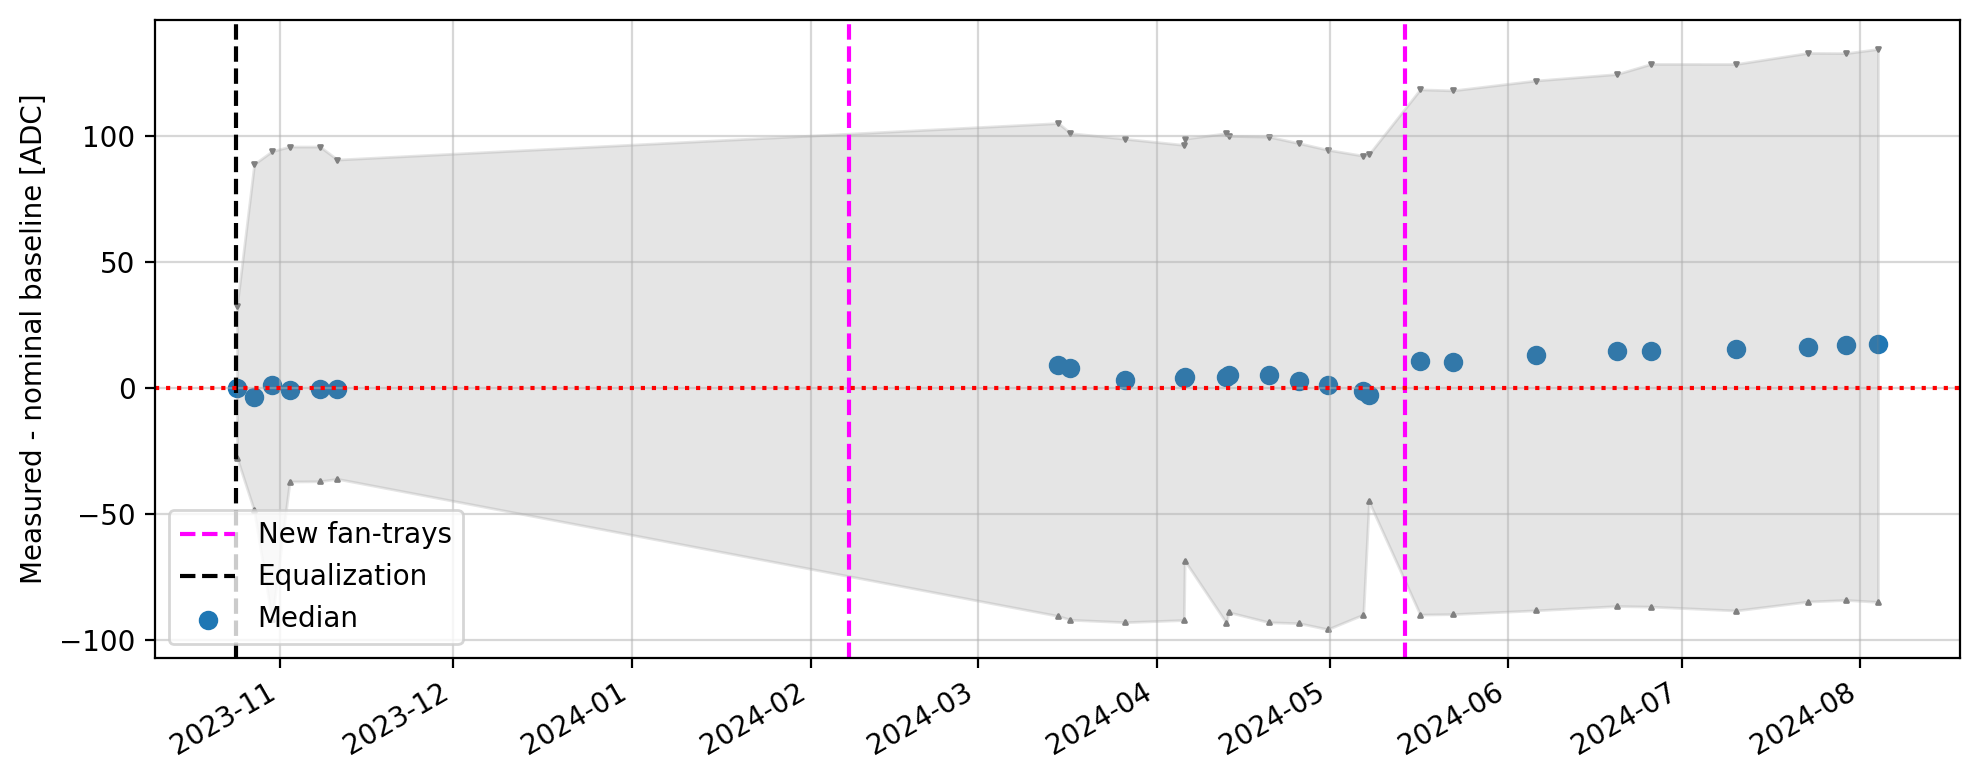

In [23]:
fig = plt.figure(figsize=(10,4),dpi=200)

plt.scatter(timestamps,bs_medians, label="Median")
#plt.scatter(timestamps,bs_means, label="Mean")
plt.scatter(timestamps,bs_pos, marker="v", s=2, color="grey")#label="Most positive outlier")
plt.scatter(timestamps,bs_neg, marker="^", s=2, color="grey")#,label="Most negative outlier")
plt.fill_between(timestamps, bs_neg, bs_pos, color='grey', alpha=0.2)

#for i,r in enumerate(runs):
#    plt.annotate( str(r), xy=(timestamps[i],bs_medians[i]),textcoords="offset points", xytext=(0,22), ha='center')

plt.axvline(x=pd.to_datetime("2024-02-07 15:51:53"), color="magenta", linestyle="dashed", label="New fan-trays")
plt.axvline(x=pd.to_datetime("2024-05-14 00:00:00"), color="magenta", linestyle="dashed")
plt.axvline(x=pd.to_datetime("2023-10-24 08:00:00"), color="black", linestyle="dashed", label="Equalization")

plt.axhline(y=0,color="red",linestyle="dotted")

plt.ylabel("Measured - nominal baseline [ADC]")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()

plt.grid(alpha=0.5)
plt.show()

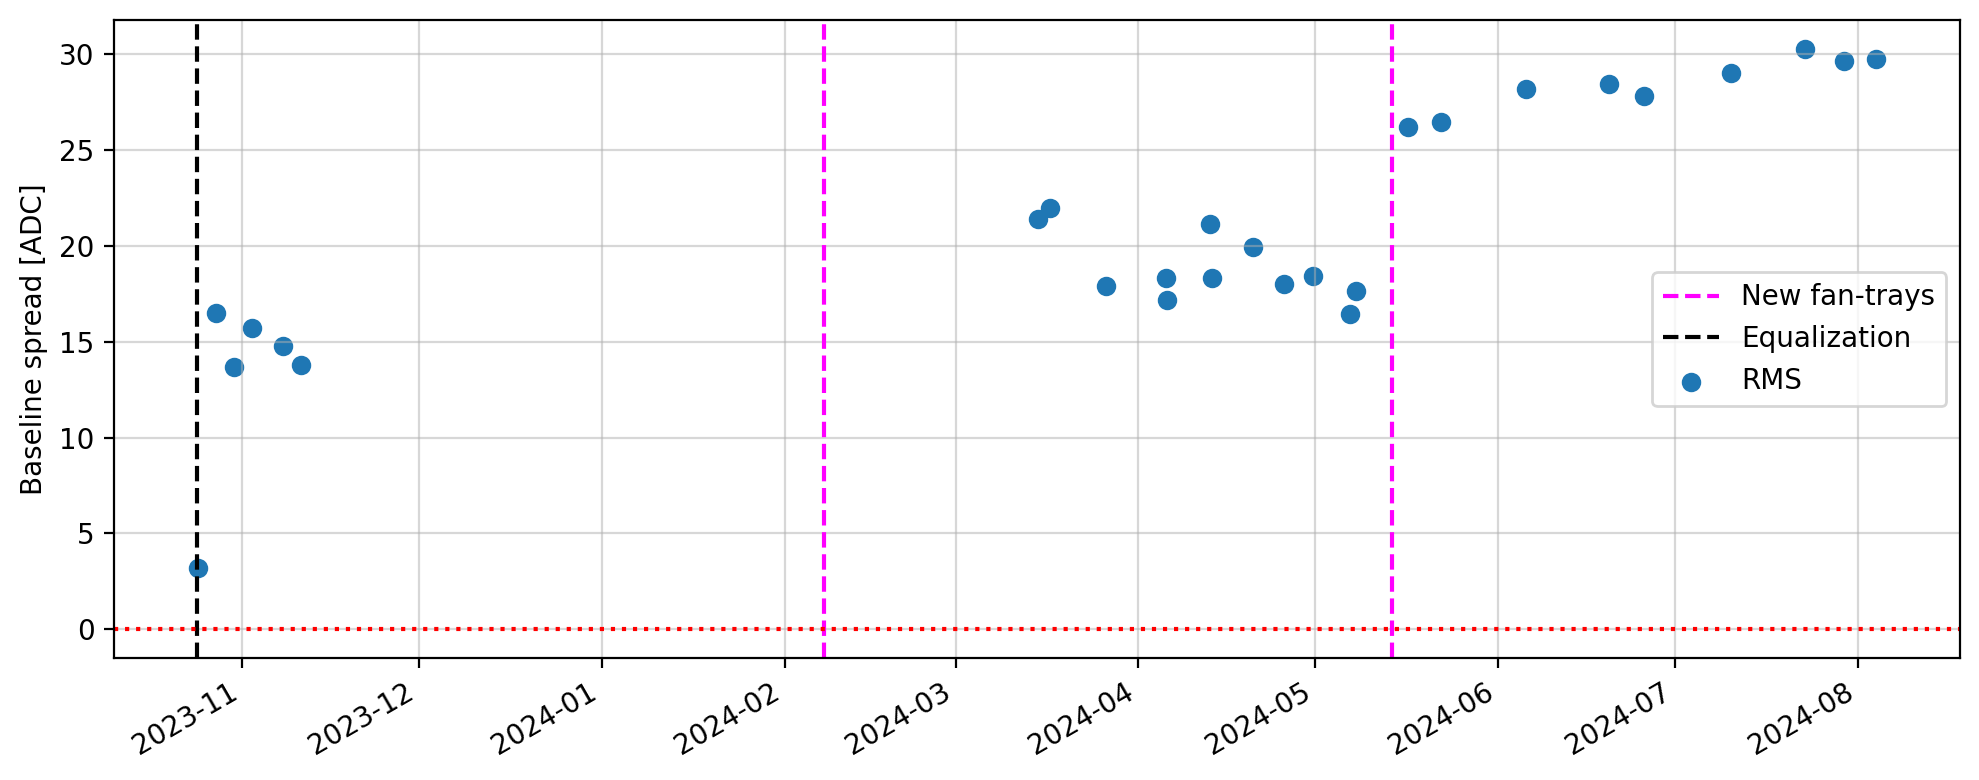

In [25]:
fig = plt.figure(figsize=(10,4),dpi=200)

plt.scatter(timestamps,bs_rmss, label="RMS")

plt.axvline(x=pd.to_datetime("2024-02-07 15:51:53"), color="magenta", linestyle="dashed", label="New fan-trays")
plt.axvline(x=pd.to_datetime("2024-05-14 00:00:00"), color="magenta", linestyle="dashed")
plt.axvline(x=pd.to_datetime("2023-10-24 08:00:00"), color="black", linestyle="dashed", label="Equalization")

plt.axhline(y=0,color="red",linestyle="dotted")

plt.ylabel("Baseline spread [ADC]")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()

plt.grid(alpha=0.5)
plt.show()